### IMDB Movies: Predictive Modeling

Solution approach: -
* All different feature types have been ultimately converted into numeric - either categorical or 1-hot encoded features.
* 'genres' text feature has been treated through 1-hot encoding into multiple new features
* 'plot_keywords' text feature is being represented through bag-of-words (CountVectorizer or TfIdfVectorizer) and then 1-hot encoding of most relevent keywords as new features. Their values are tf-idf weights.
* We are able to factor in all features except 'movie_imdb_link' and 'movie_title'.
* Tried alternatives of removing or filling empty fields.


In [0]:
# Optimize dataset size for Predictive Modeling
# Observe the impact of Data Cleaning on Performance Metrics
TRIM_DATASET = False
FEATURE_IMPORTANCE_THRESHOLD = 0.10

# Apply SkLearn MinMaxScaler on Features dataframe
NORMALIZE_DATASET = True

# Bins count for categorization of ALL numeric data (except genres/plot_keywords) into Quantiles - even Label is categorized into these many bins
BINS_COUNT_FEATURES = 10
BINS_COUNT_LABEL = 5

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing, model_selection, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# 'imdb_score' is the LABEL column

df_movie_original = pd.read_csv("/content/gdrive/My Drive/my_google_colab/movie_metadata.csv")
df_movie = df_movie_original.copy(deep=True)
print(df_movie.columns.values)

['color' 'director_name' 'num_critic_for_reviews' 'duration'
 'director_facebook_likes' 'actor_3_facebook_likes' 'actor_2_name'
 'actor_1_facebook_likes' 'gross' 'genres' 'actor_1_name' 'movie_title'
 'num_voted_users' 'cast_total_facebook_likes' 'actor_3_name'
 'facenumber_in_poster' 'plot_keywords' 'movie_imdb_link'
 'num_user_for_reviews' 'language' 'country' 'content_rating' 'budget'
 'title_year' 'actor_2_facebook_likes' 'imdb_score' 'aspect_ratio'
 'movie_facebook_likes']


In [0]:
# 'genres', '*-likes', 'director/actor-names' would be much more valuable features than 'movie_title'
# 'movie_imdb_link' can be explored through web scraping to extract any relevant context

df_movie.drop(['movie_imdb_link', 'movie_title'], axis=1, inplace=True)

In [6]:
# 'plot_keywords' can be used through bag-of-words representation (document term frequency or tf-idf)
# NOTE that though 'plot_keywords' looks quite similar to 'genres' but there are too many keywords, hence countvectorizer or tfidfvectorizer needs to be applied
# Note that 1-hot encoding of tfidf features/words adds (22) new columns

# Gensim could have been alternatively used for Text Corpus pre-processing (tokenization, stopwords/punctuations/etc removal, lemmatization)

from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from string import punctuation
from nltk.corpus import stopwords
from nltk import word_tokenize
 
stop_words = stopwords.words('english') + list(punctuation)
 
def tokenize(text):
    words = word_tokenize(text)
    words = [w.lower() for w in words]
    return [w for w in words if w not in stop_words and not w.isdigit()]

df_movie = df_movie.dropna(subset = ['plot_keywords'])
df_movie['plot_keywords'] = df_movie['plot_keywords'].apply(lambda row: re.sub("\|", " ", row.strip()))

tfidf_vect = TfidfVectorizer(tokenizer=tokenize, min_df=0.02, max_features=100)
X_train_vect = tfidf_vect.fit_transform(df_movie['plot_keywords'])
plot_cols = ('plot_' + pd.Series(tfidf_vect.get_feature_names())).tolist()

df_movie = df_movie.join(pd.DataFrame(tfidf_vect.fit_transform(df_movie.pop('plot_keywords')).toarray(),
                          columns=plot_cols,
                          index=df_movie.index))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
# 'genres' 1-hot encoding
# Note that 1-hot encoding adds (26) new columns for all 'genres' types
# Note that if we treat 'genres' as Categorical feature, then their differential impact to 'imdb_score' will be lost!

from sklearn.preprocessing import MultiLabelBinarizer

df_movie['genres'] = df_movie['genres'].apply(lambda row_genres: row_genres.split('|'))
mlb_genres = MultiLabelBinarizer()
df_movie = df_movie.join(pd.DataFrame(mlb_genres.fit_transform(df_movie.pop('genres')),
                          columns=('genres_' + pd.Series(mlb_genres.classes_)).tolist(),
                          index=df_movie.index))

genres_cols = ('genres_' + pd.Series(mlb_genres.classes_)).tolist()

In [0]:
from sklearn import preprocessing

# Identify non-numeric features and convert them into categorical features
cols_encode = df_movie.select_dtypes(include=['object']).columns

# Filling empty/nan before attempting label-encoding
df_movie.fillna({'color': 'Color', 
                  'language': 'English',
                  'country' : 'USA',
                  'director_name' : 'myself',
                  'actor_1_name' : 'myself',
                  'actor_2_name' : 'myself',
                  'actor_3_name' : 'myself',
                  'content_rating' : 'unrated'}, 
                 inplace=True)

for col in cols_encode:
  df_movie[col] = preprocessing.LabelEncoder().fit_transform(df_movie[col])

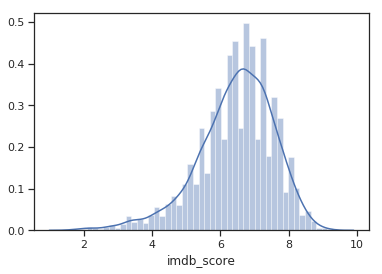

In [9]:
# Below plots are for original features, i.e., excluding 1-hot encoded features as they do not mean much alone

import seaborn as sns; sns.set(style="ticks", color_codes=True)

df_movie_tmp = df_movie.drop((genres_cols + plot_cols), axis=1)
df_movie_tmp.fillna(df_movie.mean(), inplace=True)

feats = list(df_movie_tmp.columns)
feats.remove('imdb_score')

# Label histogram
sns.distplot(df_movie_tmp['imdb_score'])

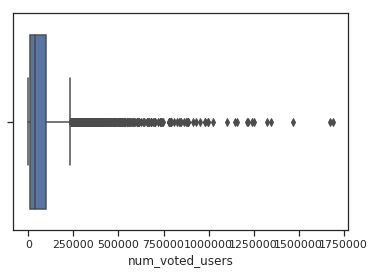

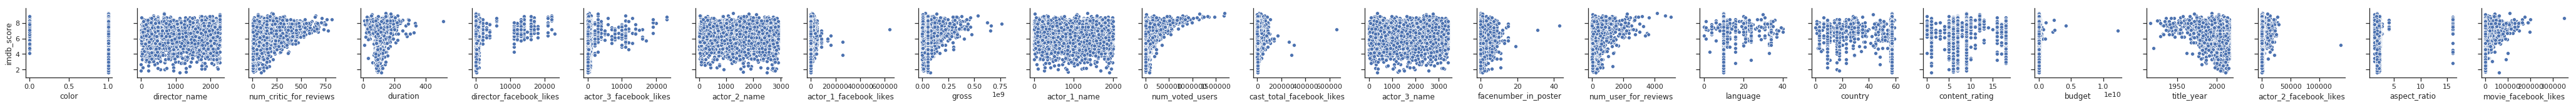

In [10]:
# Observe 'num_voted_users' - it shows some trend (see pairplot)
# This trend would have been better if outliers/noise were not there so much (see its boxplot)

sns.boxplot(x=df_movie_tmp['num_voted_users'])
sns.pairplot(data=df_movie_tmp, y_vars=['imdb_score'], x_vars=feats)

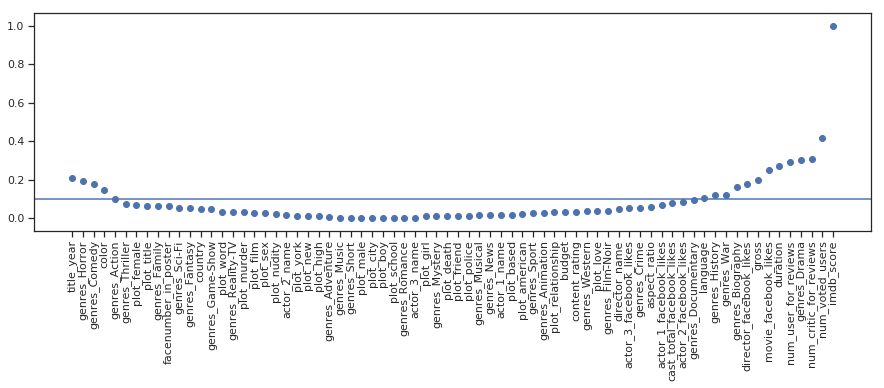

In [11]:
# Features Correlation

features_corr = df_movie.corr().sort_values(by=['imdb_score'])
weak_features = list(features_corr.loc[abs(features_corr.imdb_score) < FEATURE_IMPORTANCE_THRESHOLD, 'imdb_score'].index)
#features_corr.loc[:, 'imdb_score']

x = abs(features_corr.loc[:, 'imdb_score'])
y = features_corr.index

plt.figure(figsize=(15, 4))
plt.xticks(rotation=90)
plt.axhline(y=FEATURE_IMPORTANCE_THRESHOLD)
plt.scatter(y, x)

#import seaborn as sns
#sns.heatmap(features_corr)

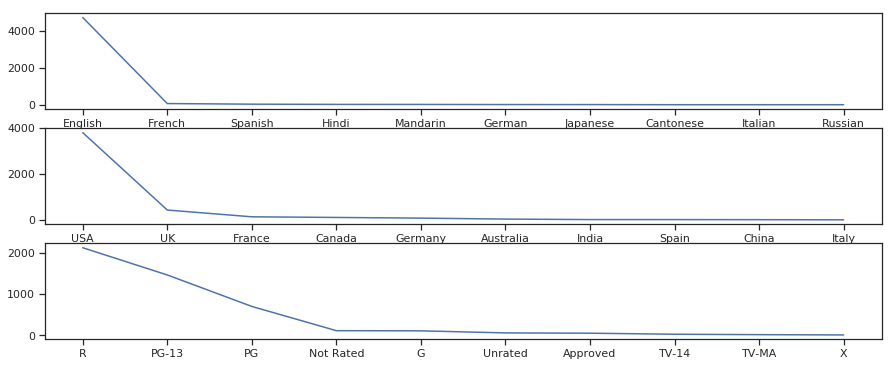

In [12]:
# Visual of how country/language/color/content_rating are distributed across their categories

fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(311)
ax1.plot(df_movie_original.language.value_counts().head(10))

ax2 = fig.add_subplot(312)
ax2.plot(df_movie_original.country.value_counts().head(10))

ax3 = fig.add_subplot(313)
ax3.plot(df_movie_original.content_rating.value_counts().head(10))

plt.show()

In [0]:
if TRIM_DATASET == True:
  # Drop rows with missing 'gross' value (~23% of dataset)
  df_movie = df_movie.dropna(subset = ['gross'])
  print(df_movie.shape)

  # Dropping weak features whose correlation with Label is < FEATURE_IMPORTANCE_THRESHOLD
  df_movie.drop(weak_features, axis=1, inplace=True)
  print(df_movie.shape)

In [14]:
# Fill empty/nan with corresponding column mean
df_movie.fillna(df_movie.mean(), inplace=True)
df_movie.describe()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,actor_1_name,...,genres_Mystery,genres_News,genres_Reality-TV,genres_Romance,genres_Sci-Fi,genres_Short,genres_Sport,genres_Thriller,genres_War,genres_Western
count,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4.890000e+03,4890.000000,...,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000,4890.000000
mean,0.957873,1203.678732,143.565083,107.620033,701.231283,658.479992,1457.783436,6679.595331,4.892945e+07,991.694888,...,0.099387,0.000409,0.000409,0.223108,0.124949,0.001022,0.037219,0.281800,0.042740,0.018814
std,0.200899,672.986559,121.058157,25.175905,2811.660564,1684.743176,848.692350,14762.231185,6.298018e+07,574.637280,...,0.299211,0.020222,0.020222,0.416373,0.330695,0.031963,0.189317,0.449922,0.202292,0.135881
min,0.000000,0.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.620000e+02,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,628.250000,54.000000,94.000000,8.000000,141.000000,718.000000,634.000000,8.460991e+06,482.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1219.500000,114.000000,104.000000,54.000000,383.000000,1452.500000,1000.000000,3.606907e+07,979.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1806.000000,197.000000,118.000000,221.000000,642.000000,2197.000000,11000.000000,5.291827e+07,1484.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,2277.000000,813.000000,511.000000,23000.000000,23000.000000,2914.000000,640000.000000,7.605058e+08,1998.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
# Identify numeric & categorical features to be discretized as ordinal values into quantile bins (including 'imdb_score')

# Note that this discretization is suitable for numeric and category features
# This discretization is not suited for 1-hot encoded text features

features_to_bin = list(df_movie_original.select_dtypes(include=['number', 'category']).columns)
features_to_bin = [value for value in df_movie.columns if value in features_to_bin]
features_to_bin.remove('imdb_score')

#prefixes = ('genres_', 'plot_')
#for word in cols_to_bin:
#  if word.startswith('genres_') or word.startswith('plot_'):
#    cols_to_bin.remove(word)

In [16]:
from sklearn.preprocessing import KBinsDiscretizer

kbd_features = KBinsDiscretizer(n_bins=BINS_COUNT_FEATURES, encode='ordinal', strategy='quantile')
kbd_label = KBinsDiscretizer(n_bins=BINS_COUNT_LABEL, encode='ordinal', strategy='quantile')

df_movie[features_to_bin] = kbd_features.fit_transform(df_movie[features_to_bin])

# SkLearn gotcha in its estimators that it expects 2D data
df_movie[['imdb_score']] = kbd_label.fit_transform(df_movie[['imdb_score']])

df_movie.head()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 13 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,actor_1_name,...,genres_Mystery,genres_News,genres_Reality-TV,genres_Romance,genres_Sci-Fi,genres_Short,genres_Sport,genres_Thriller,genres_War,genres_Western
0,1,881,9.0,9.0,0.0,8.0,1347,5.0,8.0,250,...,0,0,0,0,1,0,0,0,0,0
1,1,757,9.0,9.0,7.0,9.0,2123,9.0,8.0,936,...,0,0,0,0,0,0,0,0,0,0
2,1,1923,9.0,9.0,0.0,2.0,2386,7.0,8.0,331,...,0,0,0,0,0,0,0,1,0,0
3,1,360,9.0,9.0,8.0,9.0,505,9.0,8.0,1872,...,0,0,0,0,0,0,0,1,0,0
5,1,97,9.0,8.0,7.0,6.0,2443,2.0,7.0,417,...,0,0,0,0,1,0,0,0,0,0


### Linear Regression

* Observe the LR Model Coefficients for NORMALIZE_DATASET vs not normalized
* Also, observe that Performance Metrics on validation dataset would be exactly same irrespective of NORMALIZE_DATASET
* Categorical -vs- One-hot Encoding of non-numerical features
  * One-hot encoding expands single features like 'genres' into multiple features like 'genres_action', 'genres_comedy', etc. Note that if we treat 'genres' as Categorical feature, then their differential impact to 'imdb_score' will be lost!
  * Categorical is suited for all name features


In [17]:
X = df_movie.loc[:, df_movie.columns != 'imdb_score']
y = df_movie['imdb_score']

if NORMALIZE_DATASET == True:
  # Normalizing features
  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  X = pd.DataFrame(X_scaled)

validation_size = 0.20
seed = 7
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(X, y, test_size=validation_size, random_state=seed)

lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_pred_LR = lr.predict(X_validation)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [18]:
print('Coefficients: \n', lr.coef_)
print("Mean squared error: %.2f" % mean_squared_error(y_validation, y_pred_LR))

# Explained variance score: 1 is perfect prediction
print('Explained Variance Score: %.2f' % r2_score(y_validation, y_pred_LR))

Coefficients: 
 [-3.80111075e-01  1.47928448e-01  6.63804767e-01  5.66821976e-01
  2.37090445e-01 -3.24366137e-01 -1.52993676e-02  8.75904083e-02
  1.57770413e-02  8.68717419e-02  2.71659162e+00 -2.48792538e-01
 -2.88498845e-02 -4.20093642e-02 -1.12431804e+00  1.03149259e+00
 -2.90732284e-01  1.15932784e+00 -7.51911582e-01 -1.01955168e+00
 -7.90895313e-03 -7.15601728e-02  3.45752895e-01  7.14351957e-02
  2.88242708e-01  1.22989318e-01  5.87988451e-02 -1.40561677e-02
 -3.73112695e-01  1.21888768e-01  8.26585159e-02  6.20656739e-02
 -1.60307212e-01  1.90933272e-01 -3.68410260e-01 -2.68111713e-01
 -2.35068256e-01 -1.86792188e-01  1.41238704e-01  5.21677184e-02
  8.75881531e-02 -1.85276293e-01  9.72586371e-04  1.58046454e-01
  5.78173090e-02 -3.43519204e-01  2.70224193e-02  8.87286425e-01
  2.12524002e-01 -2.84065883e-01  4.55213562e-03  1.47372833e+00
  5.24855089e-01 -1.47913371e-01 -1.44056050e-01  7.45268220e-01
  1.45716772e-16  1.93256630e-01 -6.11485792e-01 -1.19342701e-01
  2.29846

### Clustering: K-Means

* K-Means is a unsupervised algorithm

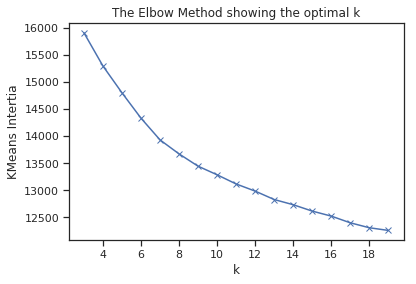

In [19]:
from sklearn.cluster import KMeans

# init (k-means++): k-means++ is SkLearn smart apporach of Clusters Centroid initalization for speedy convergence of intertia (sum-of-sq-dist)
# n_init (10): No of attempts of Clusters Centroid random initialization for picking best among them
# max_iter (300) & tol (1e-4) are to specify how long to iterate

intertias = []
cluster_counts = range(3, 20)

for i_cluster in cluster_counts:
  kmeans_model = KMeans(n_clusters = i_cluster, max_iter=1000, random_state = 0).fit(X_train)
  intertias.append(kmeans_model.inertia_)
  
# Plot the elbow
plt.plot(cluster_counts, intertias, 'bx-')
plt.xlabel('k')
plt.ylabel('KMeans Intertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

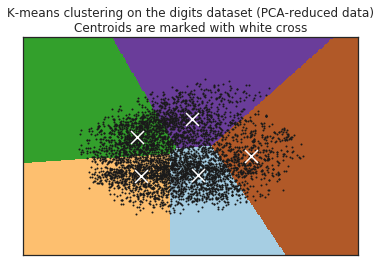

In [20]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# Ideally, this should be determined by Kmeans Elbow method of iteration
expected_categories = BINS_COUNT_LABEL

reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init='k-means++', n_clusters=expected_categories, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### Multi-class Classification - Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a random forest Classifier
clf_random_forest = RandomForestClassifier(random_state=0)

# Train the Classifier to take the training features and learn how they relate to the training y
clf_random_forest.fit(X_train, y_train)

y_preds = clf_random_forest.predict(X_validation)

accuracy_score(y_validation, y_preds)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.4550102249488753